# Image Segmentation 

In [1]:
import os
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime,date

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Create a 2 column dataframe with columns "image_path" and "label_path"

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
def gather_dataset(path):
  image_list = [os.path.join(path,x) for x in os.listdir(path) if '_mask' not in x]
  label_list = [os.path.join(path,x) for x in os.listdir(path) if '_mask' in x]
  path_df = pd.DataFrame([],columns=['image_path','label_path'])
  path_df['image_path'] = image_list
  path_df['label_path'] = label_list
  
  path_df['equal_shapes'] = [Image.open(path_df['image_path'].iloc[i]).size == Image.open(path_df['label_path'].iloc[i]).size for i in range(len(path_df))]
  path_df = path_df.where(path_df['equal_shapes']==True)
  path_df.drop(columns=['equal_shapes'])
  return path_df

path = 'C:/Link_to_D_drive/datasets/Brain_Tumor_MRI_Segmentation/kaggle_3m_jpeg'
total_df = gather_dataset(path).sample(frac=1.0)
train_df,test_df = train_test_split(total_df,train_size=0.8)
train_df,val_df = train_test_split(train_df,train_size=6/8)
for x in [train_df,val_df,test_df]:
  print(len(x))

2357
786
786


In [3]:
def load_image(image_path,label_path):
  image = tf.io.read_file(image_path)
  # image = tf.image.decode_image(image)
  image = tf.image.decode_jpeg(image)

  label = tf.io.read_file(label_path)
  # label = tf.image.decode_image(label)
  label = tf.image.decode_jpeg(label)
  return image,label

def get_dataset(df,display=False):
  dataset = tf.data.Dataset.from_tensor_slices((df['image_path'].to_list(), df['label_path'].to_list()))
  dataset = dataset.map(load_image)
  dataset = dataset.shuffle(buffer_size=1000)
  dataset = dataset.batch(batch_size=64, drop_remainder=True)
  # dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  
  
  if display:
    iterator = iter(dataset)
    image = next(iterator)
    image_np = image[0].numpy()
    label_np = image[1].numpy()
    for i in range(1,5):
      plt.imshow(image_np[i])
      plt.show()
      plt.imshow(label_np[i])
      plt.show()
  
  return dataset
train_dataset = get_dataset(train_df)
val_dataset = get_dataset(val_df)
test_dataset = get_dataset(test_df)


In [4]:


now = datetime.now()
current_time = now.strftime("%d_%m_%y_%H_%M")

num_classes=2
early_stopping = EarlyStopping(monitor='val_accuracy', patience=7)
model_checkpoint = ModelCheckpoint(filepath='./saved_models/unet_'+current_time,
                                   monitor='val_accuracy',
                                   save_best_only=True)
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

x = base_model.output
predictions = tf.keras.layers.Conv2DTranspose(
    filters=1, kernel_size=65, strides=32,
    padding='same')  #64x64 -> 128x128

model = Model(inputs=base_model.input, outputs=predictions(x))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

train_summary = model.fit(train_dataset, validation_data=val_dataset,callbacks=[early_stopping,model_checkpoint], epochs=50,batch_size=64)

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: -31.0266 - accuracy: 0.5617

INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


36/36 [==============================] - 96s 599ms/step - loss: -31.0266 - accuracy: 0.5617 - val_loss: -26.9199 - val_accuracy: 0.2356
Epoch 2/50
36/36 [==============================] - ETA: 0s - loss: -34.7023 - accuracy: 0.7225

INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


36/36 [==============================] - 21s 573ms/step - loss: -34.7023 - accuracy: 0.7225 - val_loss: -16.5790 - val_accuracy: 0.3871
Epoch 3/50
36/36 [==============================] - ETA: 0s - loss: -34.5916 - accuracy: 0.7051

INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


36/36 [==============================] - 21s 587ms/step - loss: -34.5916 - accuracy: 0.7051 - val_loss: -14.7801 - val_accuracy: 0.4329
Epoch 4/50
36/36 [==============================] - ETA: 0s - loss: -34.6437 - accuracy: 0.7389

INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


36/36 [==============================] - 21s 578ms/step - loss: -34.6437 - accuracy: 0.7389 - val_loss: 5.5468 - val_accuracy: 0.5202
Epoch 5/50
36/36 [==============================] - 7s 191ms/step - loss: -35.5814 - accuracy: 0.7606 - val_loss: -1.0001 - val_accuracy: 0.3552
Epoch 6/50
36/36 [==============================] - 7s 189ms/step - loss: -36.1562 - accuracy: 0.7928 - val_loss: 1.6460 - val_accuracy: 0.3945
Epoch 7/50
36/36 [==============================] - 8s 205ms/step - loss: -35.7352 - accuracy: 0.8157 - val_loss: 0.2243 - val_accuracy: 0.3980
Epoch 8/50
36/36 [==============================] - 8s 203ms/step - loss: -36.1995 - accuracy: 0.8197 - val_loss: 7.5111 - val_accuracy: 0.4741
Epoch 9/50
36/36 [==============================] - ETA: 0s - loss: -36.1277 - accuracy: 0.8244

INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


36/36 [==============================] - 21s 580ms/step - loss: -36.1277 - accuracy: 0.8244 - val_loss: 16.9876 - val_accuracy: 0.6063
Epoch 10/50
36/36 [==============================] - 7s 188ms/step - loss: -36.3632 - accuracy: 0.8231 - val_loss: -1.0181 - val_accuracy: 0.5389
Epoch 11/50
36/36 [==============================] - ETA: 0s - loss: -32.2371 - accuracy: 0.7005

INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


36/36 [==============================] - 21s 574ms/step - loss: -32.2371 - accuracy: 0.7005 - val_loss: 24.8420 - val_accuracy: 0.7500
Epoch 12/50
36/36 [==============================] - ETA: 0s - loss: -34.5543 - accuracy: 0.7479

INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


36/36 [==============================] - 21s 584ms/step - loss: -34.5543 - accuracy: 0.7479 - val_loss: 21.4301 - val_accuracy: 0.8133
Epoch 13/50
36/36 [==============================] - ETA: 0s - loss: -35.3593 - accuracy: 0.7859

INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


36/36 [==============================] - 21s 573ms/step - loss: -35.3593 - accuracy: 0.7859 - val_loss: 24.9953 - val_accuracy: 0.8515
Epoch 14/50
36/36 [==============================] - ETA: 0s - loss: -35.1808 - accuracy: 0.8101

INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


INFO:tensorflow:Assets written to: ./saved_models\unet_21_11_23_16_25\assets


36/36 [==============================] - 21s 572ms/step - loss: -35.1808 - accuracy: 0.8101 - val_loss: 27.4968 - val_accuracy: 0.8775
Epoch 15/50
36/36 [==============================] - 7s 189ms/step - loss: -35.2562 - accuracy: 0.8256 - val_loss: -0.3847 - val_accuracy: 0.7376
Epoch 16/50
36/36 [==============================] - 7s 190ms/step - loss: -36.0293 - accuracy: 0.8102 - val_loss: 12.7062 - val_accuracy: 0.8524
Epoch 17/50
36/36 [==============================] - 7s 190ms/step - loss: -36.5194 - accuracy: 0.8590 - val_loss: 0.4274 - val_accuracy: 0.8632
Epoch 18/50
36/36 [==============================] - 7s 190ms/step - loss: -36.1668 - accuracy: 0.8468 - val_loss: -13.5606 - val_accuracy: 0.8478
Epoch 19/50
36/36 [==============================] - 7s 192ms/step - loss: -36.4499 - accuracy: 0.8315 - val_loss: -25.4294 - val_accuracy: 0.7111
Epoch 20/50
36/36 [==============================] - 7s 191ms/step - loss: -36.0028 - accuracy: 0.8500 - val_loss: -11.0727 - val_accu

In [5]:
model.evaluate(test_dataset)

12/12 [==============================] - 1s 66ms/step - loss: -19.6847 - accuracy: 0.6533


[-19.684728622436523, 0.6533279418945312]

In [6]:
import glob
import os

list_of_files = glob.glob('./saved_models/*') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

./saved_models\unet_21_11_23_16_25


In [7]:
model.load_weights(latest_file)
model.evaluate(test_dataset)

12/12 [==============================] - 1s 58ms/step - loss: 26.3747 - accuracy: 0.8792


[26.374658584594727, 0.8792176246643066]

1/1 [==============================] - 5s 5s/step


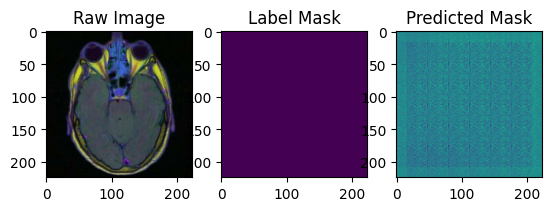

1/1 [==============================] - 0s 21ms/step


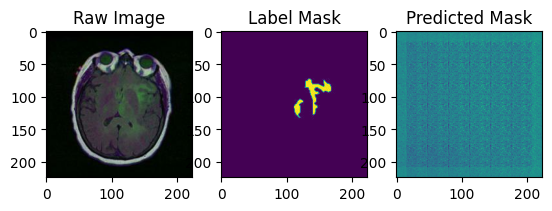

1/1 [==============================] - 0s 20ms/step


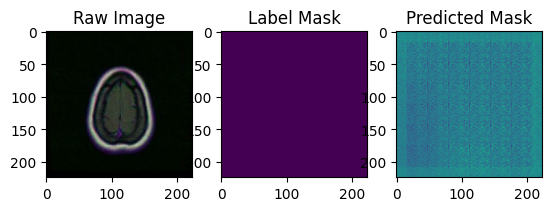

1/1 [==============================] - 0s 20ms/step


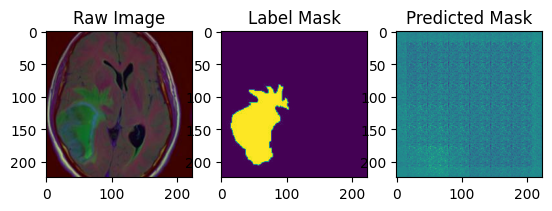

1/1 [==============================] - 0s 21ms/step


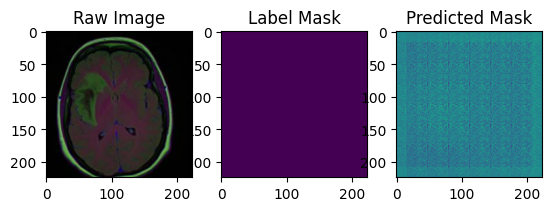

1/1 [==============================] - 0s 21ms/step


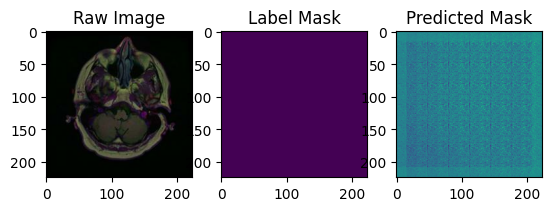

1/1 [==============================] - 0s 22ms/step


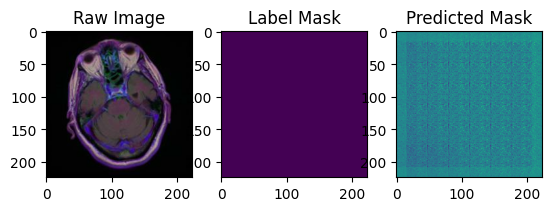

1/1 [==============================] - 0s 25ms/step


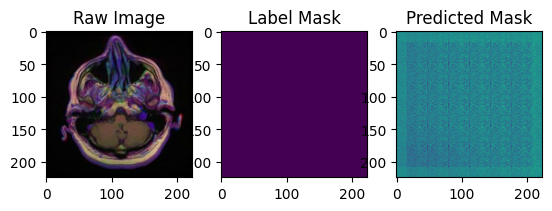

1/1 [==============================] - 0s 22ms/step


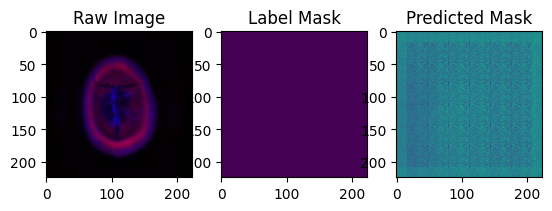

1/1 [==============================] - 0s 24ms/step


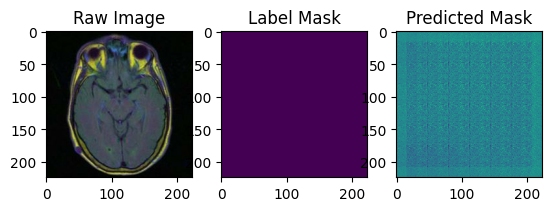

1/1 [==============================] - 0s 22ms/step


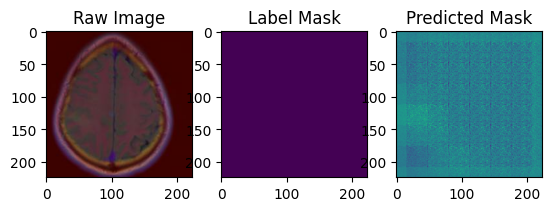

1/1 [==============================] - 0s 21ms/step


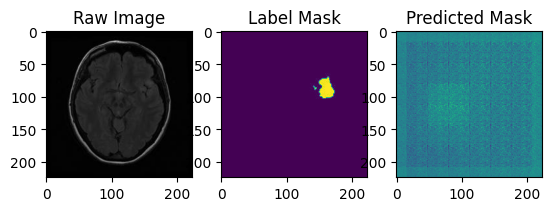

1/1 [==============================] - 0s 21ms/step


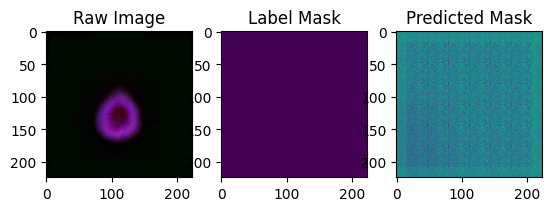

1/1 [==============================] - 0s 21ms/step


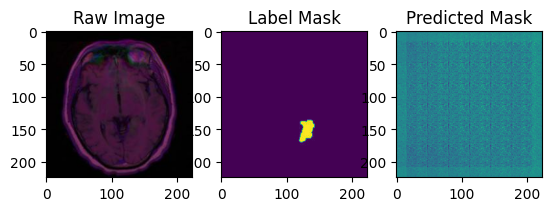

1/1 [==============================] - 0s 20ms/step


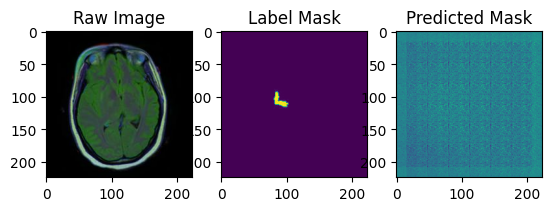

1/1 [==============================] - 0s 23ms/step


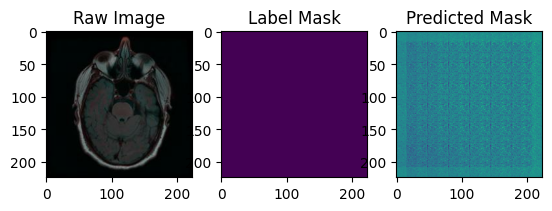

1/1 [==============================] - 0s 22ms/step


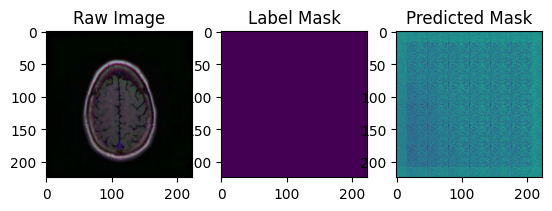

1/1 [==============================] - 0s 24ms/step


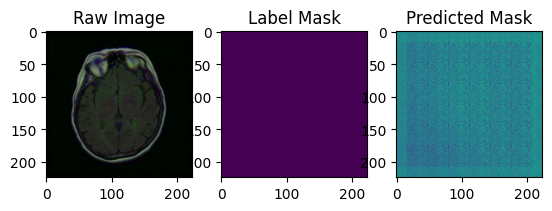

1/1 [==============================] - 0s 21ms/step


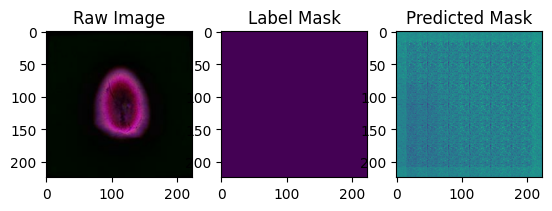

1/1 [==============================] - 0s 21ms/step


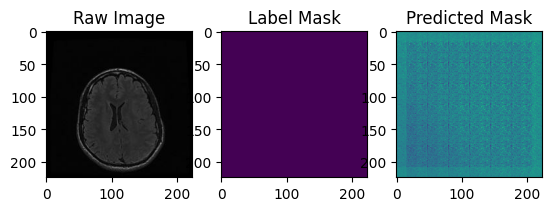

1/1 [==============================] - 0s 20ms/step


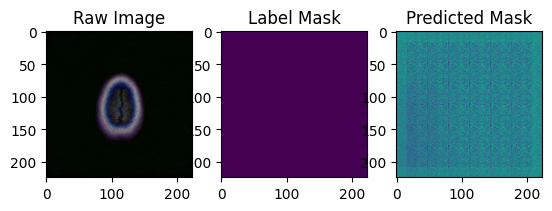

1/1 [==============================] - 0s 21ms/step


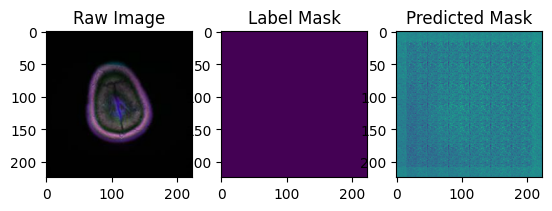

1/1 [==============================] - 0s 21ms/step


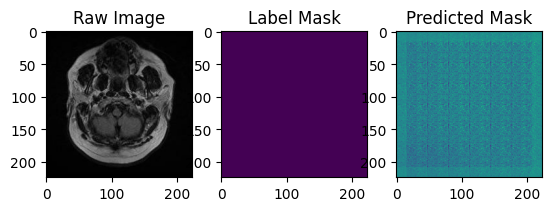

1/1 [==============================] - 0s 22ms/step


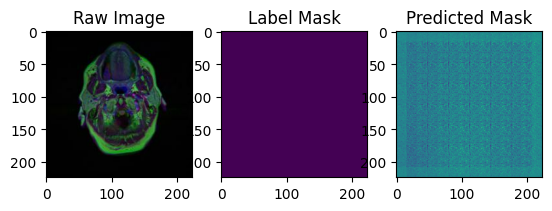

1/1 [==============================] - 0s 21ms/step


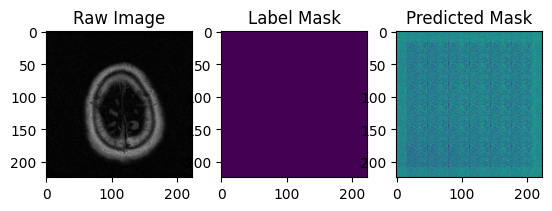

In [8]:
import numpy as np
it = iter(test_dataset)
image_label_bundle = it.next()
for i in range(25):
  image = image_label_bundle[0][i]
  label = image_label_bundle[1][i]

  predicted_image = model.predict(np.array(image).reshape((1,224,224,3)))
  
  plt.subplot(1,3,1)
  plt.title('Raw Image')
  plt.imshow(image)
  
  plt.subplot(1,3,2)
  plt.title('Label Mask')
  plt.imshow(label)
  
  plt.subplot(1,3,3)
  plt.title('Predicted Mask')
  plt.imshow(predicted_image[0])
  plt.show()
  

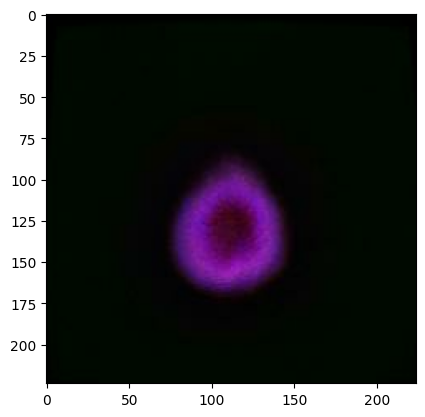

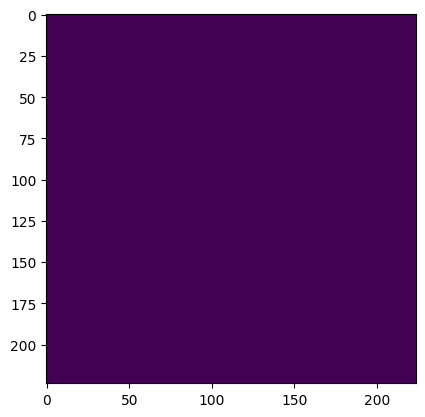

In [9]:
len(image_label_bundle)
len(image_label_bundle[0])
len(image_label_bundle[0][0])
plt.imshow(image_label_bundle[0][12])
plt.show()
plt.imshow(image_label_bundle[1][12])
plt.show()

